In [1]:
import os
from srbai.SintaktickiOperatori.stemmer_nm import stem_str
import pandas as pd
import re, string
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to C:\Users\OSD-
[nltk_data]     student1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
base_path = 'job_profil'

data = []

for faculty in os.listdir(base_path):
    faculty_path = os.path.join(base_path, faculty)
    if os.path.isdir(faculty_path):
        for job in os.listdir(faculty_path):
            job_path = os.path.join(faculty_path, job)
            if os.path.isdir(job_path):
                job_data = {'Fakultet': faculty, 'Zanimanje': job}
                for file_name in ['responsibilities.txt', 'skills.txt']:
                    file_path = os.path.join(job_path, file_name)
                    if os.path.isfile(file_path):
                        with open(file_path, 'r', encoding='utf-8') as file:
                            content = file.read()
                            if 'responsibilities' in file_name:
                                job_data['Odgovornosti'] = content
                            elif 'skills' in file_name:
                                job_data['Vjestine'] = content
                data.append(job_data)

df = pd.DataFrame(data)
df.head(100)



,Fakultet,Zanimanje,Odgovornosti,Vjestine
0,Akademija umjetnosti,Administrator umjetnosti,Planiranje i organizovanje logistike povezane ...,Komunikacijske vještine\nOrganizacijske vješti...
1,Akademija umjetnosti,Animator,Razvoj animacija na temelju klijentovih ideja\...,Umjetnički talenat\nTehničke vještine\nObraćan...
2,Akademija umjetnosti,Dizajner enterijera i prostora,Razvijanje početnog koncepta i prikupljanje kl...,"Visok nivo tehničkog znanja, uključujući vješt..."
3,Akademija umjetnosti,Dizajner keramike,Kreiranje dizajna za masovnu proizvodnju keram...,Kreativnost\nPraktične vještine u radu s keram...
4,Akademija umjetnosti,Dizajner nakita,Savjetovanje s klijentima u vezi sa njihovim s...,Kreativnost\nMaštovitost\nSposobnost rada s al...
...,...,...,...,...
95,Elektrotehnički fakultet,Inženjer automatizacije,Projektovanje automatizovanih sistema pomoću r...,Interesovanje za inženjerske nauke i tehnologi...
96,Elektrotehnički fakultet,Inženjer elektronike,Procjena novih inovacija u području elektronik...,Interesovanje za računarske operativne sisteme...
97,Elektrotehnički fakultet,IT menadžer projekta,"Analiziranje zahtjeva IT projekata, procjena p...",Liderske vještine\nKomunikacijske vještine\nOb...
98,Elektrotehnički fakultet,IT servisni inženjer,Implementacija novih IT sistema koji zadovolja...,Interesovanje za popravke uređaja ili sistema\...


In [3]:
df['Odgovornosti'].dropna(inplace=True)
df['Vjestine'].dropna(inplace=True)

In [4]:
stop_rijeci = [
    "a", "ako", "ali", "bi", "bih", "bila", "bili", "bilo", "bio", "bismo", "biste", "biti", 
    "budemo", "da", "do", "ga", "hoće", "hoćemo", "hoćete", "hoćeš", "hoću", "i", "iako",
    "ih", "ili", "iz", "ja", "je", "jedna", "jedne", "jedno", "jer", "jesam", "jesi", "jesmo",
    "jest", "jeste", "jesu", "joj", "još", "kada", "kako", "kao", "koja", "koje",
    "koji", "kojima", "koju", "kroz", "me", "mene", "meni", "mi", "moj", "moja",
    "moje", "njemu", "na", "nad", "nakon",  "nama", "nas", "naš", "naša", "naše", "našeg",
    "ne", "nego", "neka", "neki", "nekog", "neku", "nema", "neko", "neće", "nećemo", "nećete",
    "nećeš", "neću", "nešto", "ni", "nije", "nikoga", "nikoji", "nikoja", "nisam", "nisi",
    "nismo", "niste", "nisu", "njega", "njegov", "njegova", "njegovo", "njemu", "njezin",
    "njezina", "njezino", "njih", "njihov", "njihova", "njihovo", "njim", "njima", "njoj",
    "nju", "o", "od", "odmah", "on", "ona", "oni", "ono", "ova", "pa", "ipak", "po", "pod",
    "pored", "prije", "s", "sa", "sam", "samo", "se", "sebe", "sebi",  "smo", "ste", "su",
    "sve", "svi", "svog", "svoj", "svoja", "svoje", "svom", "ta", "tada", "taj", "tako", "te",
    "tebe", "tebi", "ti", "to", "toj", "tome", "tu", "tvoj", "tvoja", "tvoje", "u", "uz", "vam",
    "vama", "vas", "vaš", "vaša", "vaše", "već", "vi", "vrlo", "za", "zar", "će", "ćemo", "ćete",
    "ćeš", "ću", "šta"
]


In [5]:
def ukloni_stop_rijeci(tekst):
    rijeci_u_tekstu = tekst.split()
    
    obradjeni_tekst = [rijec for rijec in rijeci_u_tekstu if rijec.lower() not in stop_rijeci]

    obradjeni_tekst = ' '.join(obradjeni_tekst)
    return obradjeni_tekst

df['Odgovornosti'] = df['Odgovornosti'].astype(str).apply(ukloni_stop_rijeci)
df['Vjestine'] = df['Vjestine'].astype(str).apply(ukloni_stop_rijeci)
df

,Fakultet,Zanimanje,Odgovornosti,Vjestine
0,Akademija umjetnosti,Administrator umjetnosti,Planiranje organizovanje logistike povezane um...,Komunikacijske vještine Organizacijske vještin...
1,Akademija umjetnosti,Animator,Razvoj animacija temelju klijentovih ideja Izr...,Umjetnički talenat Tehničke vještine Obraćanje...
2,Akademija umjetnosti,Dizajner enterijera i prostora,Razvijanje početnog koncepta prikupljanje klju...,"Visok nivo tehničkog znanja, uključujući vješt..."
3,Akademija umjetnosti,Dizajner keramike,Kreiranje dizajna masovnu proizvodnju keramike...,Kreativnost Praktične vještine radu keramikom ...
4,Akademija umjetnosti,Dizajner nakita,Savjetovanje klijentima vezi njihovim specifik...,Kreativnost Maštovitost Sposobnost rada alatim...
...,...,...,...,...
385,Šumarski fakultet,Mašinski stolar,Razvijanje planova obradu drveta uključuju spe...,Obraćanje pažnje detalje Sposobnost prihvatanj...
386,Šumarski fakultet,Proizvođač namještaja,Korištenje raznovrsnih ručnih mašinskih alata ...,Obraćanje pažnje detalje Dizajnerske vještine ...
387,Šumarski fakultet,Službenik za arborikulturu,Pružanje stručnih savjeta očuvanju stabala okv...,Inicijativnost Interesovanje geografiju Obraća...
388,Šumarski fakultet,Čuvar prirode,"Planiranje stvaranje staništa zaštitu biljaka,...",Interesovanje biologiju Interesovanje geografi...


In [6]:
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    
    return text

In [7]:
df['Odgovornosti'] = df['Odgovornosti'].astype(str).apply(preprocess)
df['Vjestine'] = df['Vjestine'].astype(str).apply(preprocess)
df

,Fakultet,Zanimanje,Odgovornosti,Vjestine
0,Akademija umjetnosti,Administrator umjetnosti,planiranje organizovanje logistike povezane um...,komunikacijske vještine organizacijske vještin...
1,Akademija umjetnosti,Animator,razvoj animacija temelju klijentovih ideja izr...,umjetnički talenat tehničke vještine obraćanje...
2,Akademija umjetnosti,Dizajner enterijera i prostora,razvijanje početnog koncepta prikupljanje klju...,visok nivo tehničkog znanja uključujući vješti...
3,Akademija umjetnosti,Dizajner keramike,kreiranje dizajna masovnu proizvodnju keramike...,kreativnost praktične vještine radu keramikom ...
4,Akademija umjetnosti,Dizajner nakita,savjetovanje klijentima vezi njihovim specifik...,kreativnost maštovitost sposobnost rada alatim...
...,...,...,...,...
385,Šumarski fakultet,Mašinski stolar,razvijanje planova obradu drveta uključuju spe...,obraćanje pažnje detalje sposobnost prihvatanj...
386,Šumarski fakultet,Proizvođač namještaja,korištenje raznovrsnih ručnih mašinskih alata ...,obraćanje pažnje detalje dizajnerske vještine ...
387,Šumarski fakultet,Službenik za arborikulturu,pružanje stručnih savjeta očuvanju stabala okv...,inicijativnost interesovanje geografiju obraća...
388,Šumarski fakultet,Čuvar prirode,planiranje stvaranje staništa zaštitu biljaka ...,interesovanje biologiju interesovanje geografi...


In [8]:
import pandas as pd
group_by_label = df.groupby('Fakultet')
group_by_label.count()

,Zanimanje,Odgovornosti,Vjestine
Fakultet,,,
Akademija umjetnosti,33,33,33
Arhitektonsko-građevinski fakultet,28,28,28
Ekonomski fakultet,30,30,30
Elektrotehnički fakultet,23,23,23
Fakultet bezbjedosnih nauka,20,20,20
Fakultet fizičkog vaspitanja i sporta,22,22,22
Fakultet političkih nauka,18,18,18
Filološki fakultet,15,15,15
Filozofski fakultet,15,15,15


In [9]:
df["Odgovornosti"] = df["Odgovornosti"].astype(str).apply(lambda x: x.split("\n"))
df["Odgovornosti"] = df["Odgovornosti"].apply(lambda x: ' '.join(word for word in x))


In [10]:
df["Vjestine"] = df["Vjestine"].astype(str).apply(lambda x : x.split("\n"))
df["Vjestine"]  = df["Vjestine"] .apply(lambda x : ' '.join(word for word in x))

In [11]:
df

,Fakultet,Zanimanje,Odgovornosti,Vjestine
0,Akademija umjetnosti,Administrator umjetnosti,planiranje organizovanje logistike povezane um...,komunikacijske vještine organizacijske vještin...
1,Akademija umjetnosti,Animator,razvoj animacija temelju klijentovih ideja izr...,umjetnički talenat tehničke vještine obraćanje...
2,Akademija umjetnosti,Dizajner enterijera i prostora,razvijanje početnog koncepta prikupljanje klju...,visok nivo tehničkog znanja uključujući vješti...
3,Akademija umjetnosti,Dizajner keramike,kreiranje dizajna masovnu proizvodnju keramike...,kreativnost praktične vještine radu keramikom ...
4,Akademija umjetnosti,Dizajner nakita,savjetovanje klijentima vezi njihovim specifik...,kreativnost maštovitost sposobnost rada alatim...
...,...,...,...,...
385,Šumarski fakultet,Mašinski stolar,razvijanje planova obradu drveta uključuju spe...,obraćanje pažnje detalje sposobnost prihvatanj...
386,Šumarski fakultet,Proizvođač namještaja,korištenje raznovrsnih ručnih mašinskih alata ...,obraćanje pažnje detalje dizajnerske vještine ...
387,Šumarski fakultet,Službenik za arborikulturu,pružanje stručnih savjeta očuvanju stabala okv...,inicijativnost interesovanje geografiju obraća...
388,Šumarski fakultet,Čuvar prirode,planiranje stvaranje staništa zaštitu biljaka ...,interesovanje biologiju interesovanje geografi...


In [12]:
df["Zanimanje"] = df["Zanimanje"] .apply(lambda x : stem_str(x))

In [13]:
df["Odgovornosti"] = df["Odgovornosti"].apply(lambda x : stem_str(x))
df["Vjestine"]  = df["Vjestine"].apply(lambda x :  stem_str(x))

In [14]:
df

,Fakultet,Zanimanje,Odgovornosti,Vjestine
0,Akademija umjetnosti,administrator umjetnos,planir organizov logisti poveza umjetnicxk do...,komunikacij vjesxti organizacij vjesxti obrac...
1,Akademija umjetnosti,animator,razv animacij teme klijentov idej izrad scena...,umjetni talen tehnicx vjesxti obracy pazxnj d...
2,Akademija umjetnosti,dizajner enterijer i prostor,razvij pocxet koncept prikuplj kljucxn inform...,visok niv tehnicxk znanj ukljucxuj vjesxti ra...
3,Akademija umjetnosti,dizajner kerami,kreir dizaj masov proizvodnj kerami odabir od...,kreativnost prakticx vjesxti rad keramik upra...
4,Akademija umjetnosti,dizajner nakit,savjetov klijent vez njihov specifikacij diza...,kreativnost masxtovitost sposobnost rad alat ...
...,...,...,...,...
385,Šumarski fakultet,masxin stolar,razvij plan obrad drv ukljucx specificx kora ...,obracy pazxnj deta sposobnost prihvatanj krit...
386,Šumarski fakultet,proizvodxacx namjesxt,korisxtenj raznovrsn rucxn masxinsk alat prec...,obracy pazxnj deta dizajner vjesxti tim rad i...
387,Šumarski fakultet,sluzxbenik za arborikultur,pruzx strucxn savj ocxuvanj stab okvir planir...,inicijativnost interesov geograf obracy pazxn...
388,Šumarski fakultet,cxuvar prirod,planir stvar stanisxt zasxtit bilj drvecy zxi...,interesov biolog interesov geograf komunikaci...


In [15]:
df['CombinedFeatures'] = df['Odgovornosti'] + " " + df['Vjestine']
tfidf = TfidfVectorizer()

X_tfidf = tfidf.fit_transform(df['CombinedFeatures'])
X_tfidf

<390x3773 sparse matrix of type '<class 'numpy.float64'>'
	with 20234 stored elements in Compressed Sparse Row format>

In [16]:
from imblearn.over_sampling import BorderlineSMOTE

borderline_smote = BorderlineSMOTE(random_state=42, kind='borderline-1')

X_res, y_res = borderline_smote.fit_resample(X_tfidf, df['Fakultet'])

X_res


<595x3773 sparse matrix of type '<class 'numpy.float64'>'
	with 36063 stored elements in Compressed Sparse Row format>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

import numpy

pipeline_svm = Pipeline([
    ('svm', SVC()) 
])


pipeline_rf = Pipeline([
    ('rf', RandomForestClassifier())
])

pipeline_lr = Pipeline([
    ('lr', LogisticRegression())
])

pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

parameters_svm = {
    'svm__C': [0.1, 1, 10, 50, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__class_weight': [None, 'balanced']
}

parameters_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20]
}

parameters_lr = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': [ 'l2']
}

parameters_gb = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.1, 0.01, 0.001]
}

grid_search_svm = GridSearchCV(pipeline_svm, parameters_svm, n_jobs=-1, cv=5)

grid_search_svm.fit(X_train, y_train)

best_model_svm = grid_search_svm.best_estimator_

y_pred_svm = best_model_svm.predict(X_test)
y_pred_svm1 = best_model_svm.predict(X_train)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_svm1 = accuracy_score(y_train, y_pred_svm1)

print("Test Accuracy SVM:", accuracy_svm)
print(classification_report(y_test, y_pred_svm))

Test Accuracy SVM: 0.9106145251396648
                                       precision    recall  f1-score   support

                 Akademija umjetnosti       0.69      0.90      0.78        10
   Arhitektonsko-građevinski fakultet       0.64      0.90      0.75        10
                   Ekonomski fakultet       1.00      1.00      1.00        11
             Elektrotehnički fakultet       1.00      1.00      1.00        11
          Fakultet bezbjedosnih nauka       0.92      1.00      0.96        11
Fakultet fizičkog vaspitanja i sporta       1.00      0.90      0.95        10
            Fakultet političkih nauka       1.00      0.91      0.95        11
                   Filološki fakultet       1.00      0.82      0.90        11
                  Filozofski fakultet       1.00      0.70      0.82        10
                    Mašinski fakultet       1.00      1.00      1.00        11
                  Medicinski fakultet       1.00      0.91      0.95        11
             

In [18]:
grid_search_svm.best_params_

{'svm__C': 10,
 'svm__class_weight': None,
 'svm__gamma': 'scale',
 'svm__kernel': 'sigmoid'}

In [19]:
import joblib

joblib.dump(best_model_svm, 'svm_model.pkl')

['svm_model.pkl']

In [20]:
grid_search_svm

GridSearchCV(cv=5, estimator=Pipeline(steps=[('svm', SVC())]), n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 50, 100],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [21]:
grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, n_jobs=-1, cv=5)

grid_search_lr.fit(X_train, y_train)

best_model_lr = grid_search_lr.best_estimator_

y_pred_lr = best_model_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Accuracy Logistic Regression:", accuracy_lr)
print(classification_report(y_test, y_pred_lr))

X_test_texts = tfidf.inverse_transform(X_test)

results = pd.DataFrame({
    'Text': [' '.join(text) for text in X_test_texts],
    'True Class': y_test,
    'Predicted Class': y_pred_lr
})

print(results.head(2))

Accuracy Logistic Regression: 0.9050279329608939
                                       precision    recall  f1-score   support

                 Akademija umjetnosti       0.64      0.90      0.75        10
   Arhitektonsko-građevinski fakultet       0.64      0.90      0.75        10
                   Ekonomski fakultet       1.00      1.00      1.00        11
             Elektrotehnički fakultet       1.00      1.00      1.00        11
          Fakultet bezbjedosnih nauka       0.92      1.00      0.96        11
Fakultet fizičkog vaspitanja i sporta       1.00      0.90      0.95        10
            Fakultet političkih nauka       1.00      0.91      0.95        11
                   Filološki fakultet       1.00      0.82      0.90        11
                  Filozofski fakultet       1.00      0.70      0.82        10
                    Mašinski fakultet       1.00      1.00      1.00        11
                  Medicinski fakultet       1.00      0.91      0.95        11
  

In [22]:
grid_search_lr.best_params_

{'lr__C': 10, 'lr__penalty': 'l2'}

In [23]:
y_test_df = pd.DataFrame(y_test, columns=['True Class'])
y_pred_lr_df = pd.DataFrame(y_pred_lr, columns=['Predicted Class'])

y_test_df

,True Class


In [24]:
y_test_df.to_csv('y_test.csv', index=False)
y_pred_lr_df.to_csv('y_predicted.csv', index=False)

In [25]:
grid_search_rf = GridSearchCV(pipeline_rf, parameters_rf, n_jobs=-1, cv=5)

grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_

y_pred_rf = best_model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(classification_report(y_test, y_pred_rf))
print("Accuracy Random Forest:", accuracy_rf)

                                       precision    recall  f1-score   support

                 Akademija umjetnosti       0.90      0.90      0.90        10
   Arhitektonsko-građevinski fakultet       0.70      0.70      0.70        10
                   Ekonomski fakultet       0.85      1.00      0.92        11
             Elektrotehnički fakultet       0.91      0.91      0.91        11
          Fakultet bezbjedosnih nauka       0.83      0.91      0.87        11
Fakultet fizičkog vaspitanja i sporta       1.00      0.90      0.95        10
            Fakultet političkih nauka       1.00      0.91      0.95        11
                   Filološki fakultet       0.89      0.73      0.80        11
                  Filozofski fakultet       0.88      0.70      0.78        10
                    Mašinski fakultet       1.00      1.00      1.00        11
                  Medicinski fakultet       0.67      0.73      0.70        11
              Poljoprivredni fakultet       0.27   

In [26]:
grid_search_rf.best_params_

{'rf__max_depth': None, 'rf__n_estimators': 300}

In [27]:
from sklearn.neural_network import MLPClassifier

pipeline_mlp = Pipeline([
    ('mlp', MLPClassifier(max_iter=500)) 
])

parameters_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (200,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd']
}

grid_search_mlp = GridSearchCV(pipeline_mlp, parameters_mlp, n_jobs=-1, cv=5)

grid_search_mlp.fit(X_train, y_train)

best_model_mlp = grid_search_mlp.best_estimator_

y_pred_mlp = best_model_mlp.predict(X_test)
y_pred_mlp_train = best_model_mlp.predict(X_train)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_mlp_train = accuracy_score(y_train, y_pred_mlp_train)

print("Test Accuracy Neural Networks:", accuracy_mlp)
print(classification_report(y_test, y_pred_mlp))


Test Accuracy Neural Networks: 0.9050279329608939
                                       precision    recall  f1-score   support

                 Akademija umjetnosti       0.75      0.90      0.82        10
   Arhitektonsko-građevinski fakultet       0.64      0.90      0.75        10
                   Ekonomski fakultet       0.92      1.00      0.96        11
             Elektrotehnički fakultet       1.00      1.00      1.00        11
          Fakultet bezbjedosnih nauka       0.92      1.00      0.96        11
Fakultet fizičkog vaspitanja i sporta       1.00      0.90      0.95        10
            Fakultet političkih nauka       0.91      0.91      0.91        11
                   Filološki fakultet       0.91      0.91      0.91        11
                  Filozofski fakultet       0.88      0.70      0.78        10
                    Mašinski fakultet       1.00      1.00      1.00        11
                  Medicinski fakultet       1.00      0.82      0.90        11
 

In [28]:
grid_search_mlp.best_params_

{'mlp__activation': 'tanh',
 'mlp__hidden_layer_sizes': (200,),
 'mlp__solver': 'adam'}

In [29]:
import pandas as pd
from sklearn.metrics import f1_score

params_svm = grid_search_svm.best_params_
params_lr = grid_search_lr.best_params_
params_rf = grid_search_rf.best_params_
params_mlp = grid_search_mlp.best_params_

f1_svm = f1_score(y_test, y_pred_svm, average='macro') * 100
f1_lr = f1_score(y_test, y_pred_lr, average='macro') * 100
f1_rf = f1_score(y_test, y_pred_rf, average='macro') * 100
f1_mlp = f1_score(y_test, y_pred_mlp, average='macro') * 100

comparation = pd.DataFrame({
    'Model': ['SVM', 'Logistic Regression', 'Random Forest', 'Neural Network (MLP)'],
    'Best Parameters': [params_svm, params_lr, params_rf, params_mlp],
    'F1 Score (%)': [f1_svm, f1_lr, f1_rf, f1_mlp]
})

comparation



,Model,Best Parameters,F1 Score (%)
0,SVM,"{'svm__C': 10, 'svm__class_weight': None, 'svm...",90.877646
1,Logistic Regression,"{'lr__C': 10, 'lr__penalty': 'l2'}",90.381751
2,Random Forest,"{'rf__max_depth': None, 'rf__n_estimators': 300}",83.607690
3,Neural Network (MLP),"{'mlp__activation': 'tanh', 'mlp__hidden_layer...",90.232509


In [30]:
def preprocess_and_predict(text):
    remove_stop_words = ukloni_stop_rijeci(text)
    processed_text = preprocess(remove_stop_words)
    stem = stem_str(processed_text)
    print(stem)
    vectorized_text = tfidf.transform([stem])
    print(vectorized_text)
    
    prediction = best_model_svm.predict(vectorized_text)
    
    return prediction[0]

In [31]:
df1 = pd.DataFrame(data)
df1

,Fakultet,Zanimanje,Odgovornosti,Vjestine
0,Akademija umjetnosti,Administrator umjetnosti,Planiranje i organizovanje logistike povezane ...,Komunikacijske vještine\nOrganizacijske vješti...
1,Akademija umjetnosti,Animator,Razvoj animacija na temelju klijentovih ideja\...,Umjetnički talenat\nTehničke vještine\nObraćan...
2,Akademija umjetnosti,Dizajner enterijera i prostora,Razvijanje početnog koncepta i prikupljanje kl...,"Visok nivo tehničkog znanja, uključujući vješt..."
3,Akademija umjetnosti,Dizajner keramike,Kreiranje dizajna za masovnu proizvodnju keram...,Kreativnost\nPraktične vještine u radu s keram...
4,Akademija umjetnosti,Dizajner nakita,Savjetovanje s klijentima u vezi sa njihovim s...,Kreativnost\nMaštovitost\nSposobnost rada s al...
...,...,...,...,...
385,Šumarski fakultet,Mašinski stolar,Razvijanje planova za obradu drveta koji uklju...,Obraćanje pažnje na detalje\nSposobnost prihva...
386,Šumarski fakultet,Proizvođač namještaja,Korištenje raznovrsnih ručnih i mašinskih alat...,Obraćanje pažnje na detalje\nDizajnerske vješt...
387,Šumarski fakultet,Službenik za arborikulturu,Pružanje stručnih savjeta o očuvanju stabala u...,Inicijativnost\nInteresovanje za geografiju\nO...
388,Šumarski fakultet,Čuvar prirode,Planiranje i stvaranje staništa za zaštitu bil...,Interesovanje za biologiju\nInteresovanje za g...


In [32]:
import random

def get_random_responsibilities(faculties, num_responsibilities=25):
    results = {}
    for faculty in faculties:
        responsibilities_list = df1[df1['Fakultet'] == faculty]['Odgovornosti'].tolist()
        combined_responsibilities = set()
        for responsibilities in responsibilities_list:
            combined_responsibilities.update(filter(None, responsibilities.split('\n')))
        combined_responsibilities = list(combined_responsibilities)
        if len(combined_responsibilities) >= num_responsibilities:
            results[faculty] = random.sample(combined_responsibilities, num_responsibilities)
        else:
            results[faculty] = combined_responsibilities
    return results

def get_random_skills(faculties, num_skills=15):
    results = {}
    for faculty in faculties:
        skills_list = df1[df1['Fakultet'] == faculty]['Vjestine'].tolist()
        combined_skills = set()
        for skills in skills_list:
            combined_skills.update(skills.split('\n'))
        combined_skills = list(combined_skills)
        if len(combined_skills) >= num_skills:
            results[faculty] = random.sample(combined_skills, num_skills)
        else:
            results[faculty] = combined_skills
    return results

              Word  Frequency
31          dizajn          7
123     matematika          7
204        sistemi          5
97    inženjerstvo          5
81          hemija          5
25       biologija          5
184  programiranje          4
96        inženjer          4
57          fizika          4
178          pravo          4


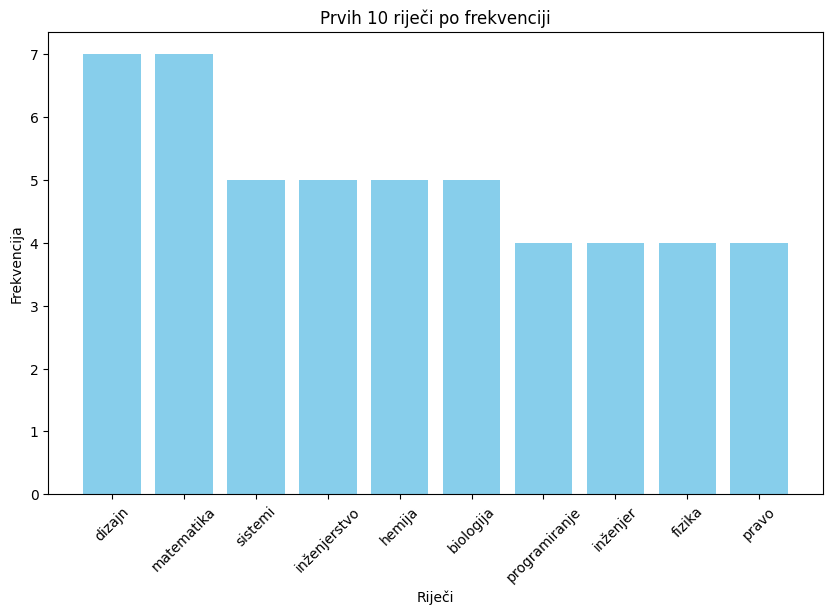

In [33]:
%run Recommendation_system.ipynb

In [34]:
recommend("Elektrotehnički fakultet")

['Prirodno-matematički fakultet - 0.6235',
 'Mašinski fakultet - 0.1863',
 'Arhitektonsko-građevinski fakultet - 0.1443']

In [35]:
from flask import Flask, request, jsonify

app = Flask(__name__)


@app.route('/random-responsibilities', methods=['POST'])
def random_responsibilities():
    data = request.get_json()
    faculties = data.get('faculties', [])
    random_responsibilities = get_random_responsibilities(faculties)
    return random_responsibilities

@app.route('/random-skills', methods=['POST'])
def random_skills():
    data = request.get_json()
    faculties = data.get('faculties', [])
    result = get_random_skills(faculties)
    return result


@app.route('/predict', methods=['POST'])
def predict_faculty():
    data = request.get_json()
    if 'text' not in data:
        return jsonify({'error': 'No text provided'}), 400
    
    text = data['text']
    try:
        prediction = preprocess_and_predict(text)
        return prediction
    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/recommend', methods=['POST'])
def recommend_faculty():
    data = request.get_json()
    faculty = data.get('faculty')
    if not faculty:
        return jsonify({'error': 'Faculty not provided'}), 400

    try:
        recommendations = recommend(faculty)
        return jsonify({"recommendations": recommendations}), 200
    except Exception as e:
        return jsonify({'error': str(e)}), 500


if __name__ == '__main__':
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.103:5000
Press CTRL+C to quit
